# Tweets analysis - topic modelling

## Importing libraries and data

In [ ]:
!python -m spacy download en_core_web_md

In [ ]:
!pip install --upgrade gensim==3.8

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

#word count
from collections import Counter

#sentiment analysis
from textblob import TextBlob

#text preprocessing
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer

#hide warning
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os       #importing os to set environment variable
import os.path
import glob

def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)


In [ ]:
df = pd.read_csv('twitter_data_sent.csv',parse_dates=['date','created','year'])

## Preprocessing for topic Modeling

In [ ]:
# tokenize each sentence into a list of words, removing punctuations
df['text_nlp'] = df['text_nlp'].str.replace('pad','phd')

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['text_nlp']))

# Remove Stop and common Words
stopwords = nltk.corpus.stopwords.words('english')
# 'home', 'stay','new','york', 'time',
newStopWords =  ['s','t',  'm', 're','don','ve','2', '3', '1', 
                 'it', 'i', 'us', 'get', 'you', 'let', 'going', 'know', 
                'make', 'take', 'still','got', 'can', 'this', 'all', 'me','go',
                'even', 'here', 'well', 'much', 'many', 'way', 'want', 'every', 'little', 'phdchat', 'phdlife']
stopwords.extend(newStopWords)

data_words = [[word for word in doc if word not in stopwords] for doc in data_words]

In [ ]:
# restrict words to only noun, adjective, verb and adverb
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 

## Finding the optimal number of topics using LdaMallet model

In [ ]:
start=24
limit=32
step=2
random = 155

# function to compute coherence values for each model. 
# This could help us choose how many topics should be included into our model.

def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# compute coherence values for each model
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit)

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 24  has Coherence Value of 0.3257
Num Topics = 26  has Coherence Value of 0.3218
Num Topics = 28  has Coherence Value of 0.3246
Num Topics = 30  has Coherence Value of 0.3568


## Finding Key Words for each topic using optimal LdaMallet model

In [ ]:
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=30, id2word=id2word)

In [ ]:
# Show Topics
model_topics = ldamallet.show_topics(formatted=False)
pprint(sorted(ldamallet.print_topics(num_words=8)))

[(0,
  '0.226*"good" + 0.224*"anxiety" + 0.051*"worry" + 0.042*"bad" + '
  '0.034*"place" + 0.032*"insane" + 0.030*"stop" + 0.027*"question"'),
 (1,
  '0.247*"academic" + 0.095*"school" + 0.048*"education" + 0.035*"pay" + '
  '0.029*"subject" + 0.027*"system" + 0.023*"culture" + 0.023*"number"'),
 (2,
  '0.248*"graduate" + 0.064*"apply" + 0.064*"child" + 0.049*"care" + '
  '0.048*"support" + 0.047*"social" + 0.032*"concern" + 0.030*"training"'),
 (3,
  '0.127*"sad" + 0.110*"friend" + 0.066*"family" + 0.066*"amazing" + '
  '0.043*"person" + 0.040*"meet" + 0.037*"colleague" + 0.034*"time"'),
 (4,
  '0.201*"write" + 0.109*"dissertation" + 0.085*"finish" + 0.078*"read" + '
  '0.059*"book" + 0.056*"paper" + 0.034*"interesting" + 0.030*"send"'),
 (5,
  '0.232*"today" + 0.088*"therapy" + 0.047*"session" + 0.044*"enjoy" + '
  '0.038*"lead" + 0.032*"art" + 0.029*"follow" + 0.029*"forward"'),
 (7,
  '0.280*"stress" + 0.107*"thesis" + 0.071*"level" + 0.056*"high" + '
  '0.054*"wait" + 0.044*"exam

In [ ]:
topics = pd.DataFrame(sorted(ldamallet.print_topics(num_words=10)))
topics.columns = ['Topic_num','Key_words']
topics.to_csv('30_topics.csv',index = False)

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3530136357526256


In [ ]:
topic_names = ['anxiety/worry/sad',
 '1',
 '2',
 'friend/family/miss',
 '4',
 'therapy/enjoy/lead',
 'sad/leave/back',
 'stress/exam/thesis',
 '8',
 'distressful/month/job',
 'graduate/finally/happy',
 'stress/dissertation/cry',
 '12',
 'find/disorder/psychiatric',
 '14',
 '15',
 'life/love/remember',
 'fellowship/recovery/support',
 'sad/news/hear',
 '19',
 'young/academic/pressure',
 'stress/dissertation/deadline',
 'kind/supervisor/worry',
 'work/lot/money',
 'career/opportunity/graduate',
 'year/end/burn',
 '26',
 'year/crazy/degree',
 'student/experience/live',
 '29']

## Topic Vector

In [ ]:
df = pd.read_csv('twitter_data_sent.csv',parse_dates=['date','year','created'])

In [ ]:
topics_docs = []
for m in ldamallet[corpus]:
    topics_docs.append(m)

train_vecs = []
for i in topics_docs:
    topic_vec = [j[1] for j in i]
    train_vecs.append(topic_vec) 

topic_dis = pd.DataFrame(train_vecs,columns=topic_names)
topic_dis.head()

df= pd.concat([df,topic_dis],axis = 1)
df.head(2)

,date,created,user_id,text,tweet_id,retweets,replies,likes,quotes,country,...,young/academic/pressure,stress/dissertation/deadline,kind/supervisor/worry,work/lot/money,career/opportunity/graduate,year/end/burn,26,year/crazy/degree,student/experience/live,29
0,2017-03-01,2017-03-01 00:18:37+00:00,106796486,Getting so stressed out about applying for gra...,836732371986755584,1,0,1,0,Great Britain,...,0.030303,0.040404,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303
1,2017-03-01,2017-03-01 10:13:30+00:00,2310165758,Finally coming to the realisation that my diss...,836882078692147200,0,0,2,0,Great Britain,...,0.028736,0.078544,0.028736,0.028736,0.030651,0.028736,0.028736,0.028736,0.028736,0.028736


## Word Vector

In [ ]:
# Creat all the interested word for analysis
Interesting_words = ['thesis','dissertation','paper','exam','deadline','due','study','work',
                 'working','studying','talk','talking','therapy','therapist','colleague','friend',
                'supervisor','family','friends','child','children','parents','book','sport','series','film',
                 'music','park','travel','tell','share', 'job','career','sleep','sleeping','night','session','game','games',
                 'lockdown','covid','isolation','virus','life','experience','money','love','kids','wine','sex','play']

In [ ]:
for col in Interesting_words:
    df[col]=df.text_nlp.apply(lambda x: int(col in str(x)))

## Country Vector

In [ ]:
country = list(df['country'].unique())

In [ ]:
# create country vector
for col in country:
    df[col]=df.country.apply(lambda x: int(str(x) == col))

## Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [ ]:
# run a lasso regression on all the variables and polarity
X = df.drop(['date', 'created', 'user_id', 'text', 'tweet_id', 'retweets', 'replies',
       'likes', 'quotes', 'country', 'quarter', 'year', 'covid', 'text_nlp',
       'text_lem', 'text_nlp_e', 'text_lem_e', 'negative', 'neutral',
       'positive', 'compound', 'sentiment'], 1)
Y = df['compound']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [ ]:
# train test split
X_test,X_train,y_test,y_train=train_test_split(X,Y, test_size=0.3, random_state=31)

In [ ]:
# run lassocv
lasso = LassoCV(cv=10, random_state=0)
lasso.fit(X_train, y_train)

LassoCV(cv=10, random_state=0)

In [ ]:
# predict y
Y_pred = lasso.predict(X_test)

In [ ]:
# performance
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
print(train_score)
print(test_score)

0.22666710487005182
0.1662114790046625


In [ ]:
# create a dictionary with feature and coeficient
coef_dict = dict(zip(list(X.columns),list(list(lasso.coef_))))
# rank feature by coeficient value
import operator
sorted_importance = sorted(coef_dict.items(), key=operator.itemgetter(1))
sorted_importance

[('stress/dissertation/cry', -7.790893541477746),
 ('stress/exam/thesis', -6.301651353117704),
 ('sad/news/hear', -5.797405597266484),
 ('student/experience/live', -4.077598646993455),
 ('26', -2.393765440333704),
 ('distressful/month/job', -1.8364565830896407),
 ('life/love/remember', -1.7359028662702694),
 ('19', -1.139670670032181),
 ('young/academic/pressure', -0.36732203611659603),
 ('work/lot/money', -0.3653120961180746),
 ('sleeping', -0.2910929618846096),
 ('career', -0.29077173322651034),
 ('money', -0.24254206287827615),
 ('travel', -0.2134894258292629),
 ('studying', -0.20268741970004764),
 ('game', -0.17279667202195512),
 ('family', -0.15598573083619402),
 ('parents', -0.14599030855384273),
 ('lockdown', -0.1397767253540261),
 ('deadline', -0.1324827222427993),
 ('12', -0.10568416788682006),
 ('isolation', -0.10045753113590299),
 ('friends', -0.093845384272508),
 ('night', -0.08687449458613002),
 ('talking', -0.08286970066763813),
 ('due', -0.04290606506129918),
 ('book', -

## Topic Modeling Analysis

In [ ]:
topic_list = df.columns[22:52]
topic_mean = df.iloc[:,22:52].mean().values

for i in range(len(topic_list)):
    df[i] = np.where(df[topic_list[i]] > 0.08,1,0)
    
topic_polarity = list()
for i in range(30):
    topic_polarity.append(df[df[i]==1]['compound'].mean())
    
topic_polarity = pd.DataFrame({'Topics':topic_list,'Polarity':topic_polarity})
topic_polarity = topic_polarity.sort_values(by = ['Polarity'])
topic_polarity = topic_polarity.loc[(topic_polarity.Topics != '29') & (topic_polarity.Topics != '14') & (topic_polarity.Topics != '2') & (topic_polarity.Topics != '8') &
                                (topic_polarity.Topics != '19') & (topic_polarity.Topics != '1') & (topic_polarity.Topics != '12') & (topic_polarity.Topics != '4') &
                               ( topic_polarity.Topics != '15') & (topic_polarity.Topics != '26')].reset_index(drop=True)
topic_polarity

,Topics,Polarity
0,stress/dissertation/cry,-0.178100
1,stress/exam/thesis,-0.160808
2,year/end/burn,-0.075983
3,student/experience/live,-0.068049
4,stress/dissertation/deadline,-0.031729
5,sad/news/hear,-0.024252
6,young/academic/pressure,-0.014470
7,kind/supervisor/worry,0.025279
8,year/crazy/degree,0.089803
9,find/disorder/psychiatric,0.138300


In [ ]:
positive = topic_polarity[topic_polarity['Polarity']>0.2].index
mild = topic_polarity[(topic_polarity['Polarity']>0) &(topic_polarity['Polarity']<=0.2)].index

Text(0.5, 1.0, 'The average polarity of all Tweets containing a topic')

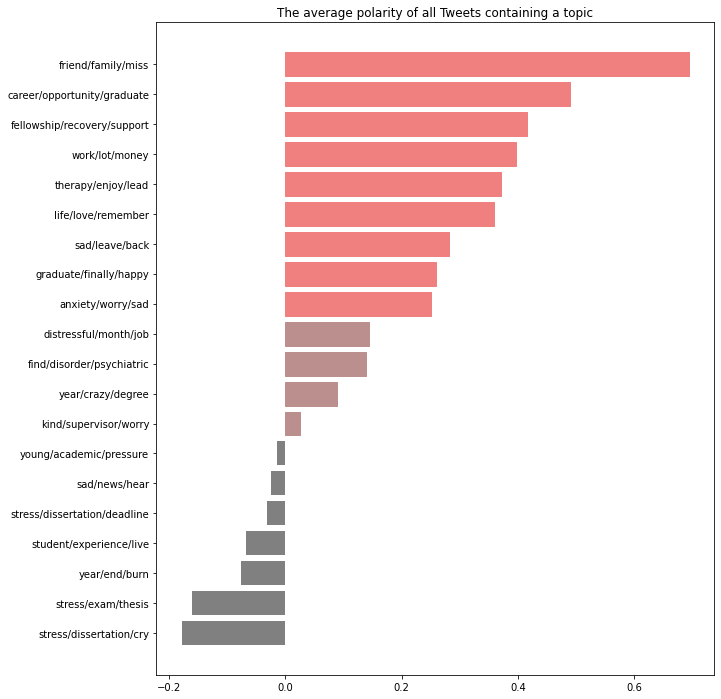

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
barlist =plt.barh(range(len(topic_polarity['Polarity'])), topic_polarity['Polarity'],color = 'grey')
ax.set_yticks(range(len(topic_polarity['Polarity'])))
ax.set_yticklabels(topic_polarity['Topics'])
plt.rc('xtick', labelsize=10) 
for word in positive:
    barlist[word].set_color('lightcoral')
for word in mild:
    barlist[word].set_color('rosybrown')
plt.title('The average polarity of all Tweets containing a topic')

## Single-word analysis

In [ ]:
special_words = ['thesis','dissertation','paper','exam','deadline','due','study','work',
                 'working','studying','talk','talking','therapy','therapist','colleague','friend',
                'supervisor','friends','child','children','parents','book','sport','series',
                 'music','tell','share', 'job','career','sleep','sleeping','night','session','game',
                 'lockdown','covid', 'life','experience','money','love','wine','play']
avg_polarity = list()
num_texts = list()
for word in special_words:
    avg_polarity.append(df[df['text_nlp'].str.match(word, na=False)]['compound'].mean())
    num_texts.append(len(df[df['text_nlp'].str.match(word, na=False)]))

In [ ]:
activity = pd.DataFrame()
activity['activity'] = special_words
activity['avg_polarity'] = avg_polarity
activity['num_texts'] = num_texts
activity= activity.sort_values(by = ['avg_polarity'],ascending = True)
activity.reset_index(inplace = True)
activity.drop('index',axis = 1,inplace = True)

In [ ]:
positive = activity[activity['avg_polarity']>0.2].index
mild = activity[(activity['avg_polarity']>0) &(activity['avg_polarity']<=0.2)].index

Text(0.5, 1.0, 'The average polarity of all Tweets containing a keyword')

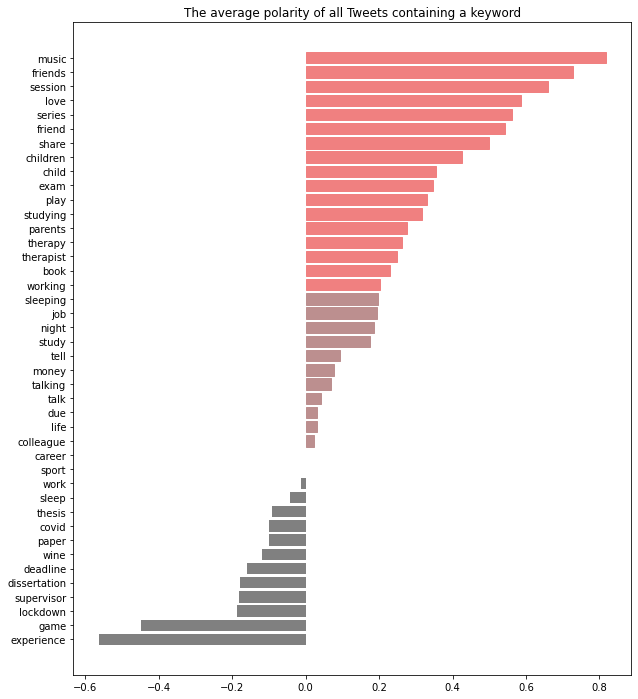

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
barlist =plt.barh(range(len(activity['avg_polarity'])), activity['avg_polarity'],color = 'grey')
ax.set_yticks(range(len(activity['avg_polarity'])))
ax.set_yticklabels(activity['activity'])
plt.rc('xtick', labelsize=10) 
for word in positive:
    barlist[word].set_color('lightcoral')
for word in mild:
    barlist[word].set_color('rosybrown')
plt.title('The average polarity of all Tweets containing a keyword')